Curtis Sera <br>
v2.0.5 <br>
2020-11-06

# Protrusion body: before and after fusion

## Introduction
This is a simple comparison of the bending energies for a fusion event occuring in the <i>Bt</i> protrusion body.  Starting with the protrusion set-up shown on the left and ending with the geometry shown on the right:
<img src="Imgs/base_fusion.jpg" width=600 /><br>
except that the scission occurs within the protrusion body, leaving 2 rims rather than 1 rim and 1 fusion pore in the bulk.

We will again split the protrusion into three idealized sections: toroidal base, cylindrical body, hemispherical cap.  We will further make the simplifying assumptions that only the toroidal base has changed geometry (perhaps this is very shortly after fusion) and that any excess membrane has been able to flow into a stress-free bulk.  Thus, our expression for the change in bending energy is simply:

$\Delta G = (2 G_{body rim} ) - G_{body segment}$
where we have multiplied the body rim energy by 2 in recognition of the symmetry.

That is, within this model we don't need to pay attention to anything other than the base and what it turns into.

The relevant comparisons are for a fusion without a protrusion, fusion in the body, and fusion in the cap.  To make complete comparisons, it would be ideal to fully calculate pore + residual membrane energies for each situation.  However, the pore energy is not needed to make the base fusion vs protrusion-less fusion comparison since the pore energy is the same in those cases once the protrusion has been cut off.

## Set-up
To get started, let's first set our key system properties.  We'll be using the same variable names as in FusionPoreExpanG.ipynb.  The scheme for the protrusion base is shown on the left, and the scheme for a the protrusion base's post-fusion rim is shown on the right (adapted from the fusion pore scheme).  The coordinates/variables for the pre-fusion base are used identically in the body.

<img src="Imgs/tor_base_xsection.jpg" width=550 />   <img src="Imgs/base_rim.jpg" width=550 />

Note that the diagram for the rim is not to scale.

We will make the rim toroidal (the bottom of a donut), and $r_{t,rim}$ will be the intermembrane distance.  Two intermembrane distance range will include 25 nm which is what I measured from 2019-08-05's infected-0040.tif and which is ~consistent with the known ER intermembrane distance of 30 nm.

In [7]:
import numpy as np
import plotly.graph_objs as go

# Membrane properties
Kb = 15         # kT

# Pre-fusion properties
R0 = 375        # nm
Rt = 200        # nm

# Post-fusion properties
rim_rt = np.array([2,2.3,2.6,3,3.5,4,5,6.5,8,10,
                   12.5,15,17.5,20,22.5,25,30,35,40,45])    # nm
    # the intermembrane distance of the residual protrusion
    # (ie toroidal rim's tube radius)

def helfrichStress(k1,k2,Kb):
    '''
    Helfrich bending *stress*
    
    Args:
        k1 (float): Principal curvature 1; 1/nm
        k2 (float): Principal curvature 2; 1/nm
        Kb (float): Helfrich bending constant for membrane; kT/nm^2
    Returns:
        float: The Helfrich bending *stress* (ie energy for an infinitesimal dA) 
    '''
    return 0.5*Kb*(k1+k2)**2 # Note units = energy/unit area = kT/nm^2

def torusCircCurv(R,r,u):
    '''
    Curvature (reciprocal of radius of curvature) on a torus at a point defined by the angle u due 
    to connecting the tube ends.  The "circumferential curvature".
    
    Args:
        R (float): distance from torus center to inner wall; nm
        r (float): torus tube radius; nm
        u (float): angle giving location on the relevant slice of tube where 0 points transversely *out*; radians
    Returns:
        float: Circumferential curvature; 1/nm
    '''
    return (np.cos(u)) / (R + r + r*np.cos(u));

def GToroidalPore(R,r,Kb):
    '''
    Bending energy for a toroidal pore *with no spontaneous curvature*.
    
    Args:
        R (float): distance from torus center to inner wall; nm
        r (float): torus tube radius; nm
        Kb (float): Helfrich bending constant for membrane; kT/nm^2
    Returns:
        float: Pore bending energy; kT
    '''
    return Kb*np.pi*2* ( np.arctan(np.sqrt((r+2*R)/r)) * (2*(r+R)**2)/(R*np.sqrt(r**2+2*R*r)) - 4 );

## Computation: pre-fusion body

**Assume:**
- The area of body membrane that will be freed = $1.5 \,\, 2 \pi r_{t,rim}$
    - This is the area of membrane that will be incorporated into the post-fusion rims * 1.5.
    - *Implicitly assumes that the are incorporated into the rims is freed and that an additional 0.5 times that area retracts into the bulk*

Note that the body is cylindrical which makes its stresses uniform.  Thus, we need only find the per unit area energy then multiply that by the relevant area.  Since this depends on $r_{t,rim}$, this will have multiple pre-fusion energies unlike the cap and base pre-fusion vs post-fusion comparisons.

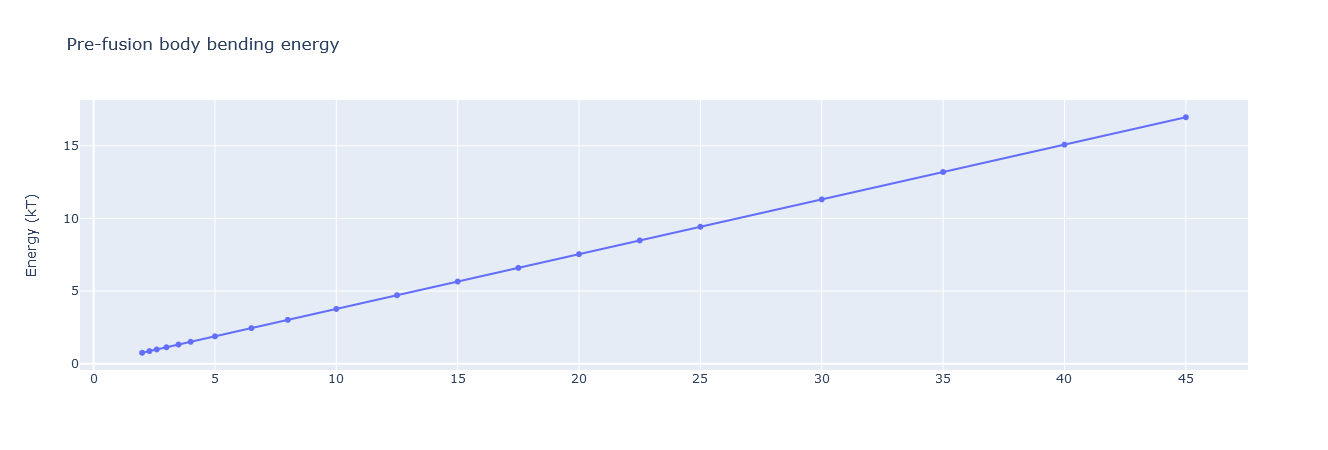

Total Gb of pre-fusion body =  [ 0.75398224  0.86707957  0.98017691  1.13097336  1.31946891  1.50796447
  1.88495559  2.45044227  3.01592895  3.76991118  4.71238898  5.65486678
  6.59734457  7.53982237  8.48230016  9.42477796 11.30973355 13.19468915
 15.07964474 16.96460033]  kT


In [8]:
stressPre = helfrichStress(1/R0,0,2*Kb) # 2*Kb since two membranes

GPre = np.zeros(rim_rt.size)
for rt in range(0,rim_rt.size):
    GPre[rt] = stressPre * 2*R0*np.pi*1.5*rim_rt[rt]

prePlot = go.Figure()
prePlot.add_trace(go.Scatter(x=rim_rt, y=GPre, mode='markers + lines'))
prePlot.update_layout(title="Pre-fusion body bending energy",
                        xaxis_title="$r_{t,prtr}$ (nm)", yaxis_title="Energy (kT)")
prePlot.show()

print("Total Gb of pre-fusion body = ",GPre," kT")

Validation of my "simulation parameter" validation:
- Dividing the z axis in to 1+Rt*n steps.  Choosing n=4 appears to be quite sufficient.  The final figure for GPre changes only slightly for n=2-->4, and there is no meaningful difference from n=4-->1000
    - Pass!

## Computation: post-fusion body rims via z-axis Riemann sum in cylindrical coordinates

*Caution: It is tempting to apply Christoph and Rob's (2011 paper) solution for conical pores to this situation.  However, we cannot.  Their conical set-up requires an imagined vertex that the membrane would converge to.  On the other hand, my cylindrical set-up is at a 90 degree rotation (where 0 is a perfectly flat membrane) and would only have such a vertex if the tube radius was infinitely thin.  We must therefore calculate this via direct application of toroidal geometry.*

This method poses the problem that each location on the z axis corresponds to 2 angles (except at the end).  However, we can use the same trigonometric method that we used in the previous section:

$u_{rim} = \left\{ \pi - arcsin \left(\frac{R_t - z}{R_t} \right) \cup arcsin \left(\frac{R_t - z}{R_t} \right) \right\}$

Note that this will double-count $u_{rim} = \pi/2$, but that shouldn't be a huge problem since its contribution will be small compared to the whole.

*The rim energy, GPost, is multiplied by 2 at the end of this calculation to reflect the presumed symmetry on either side of the "cut" within the body*

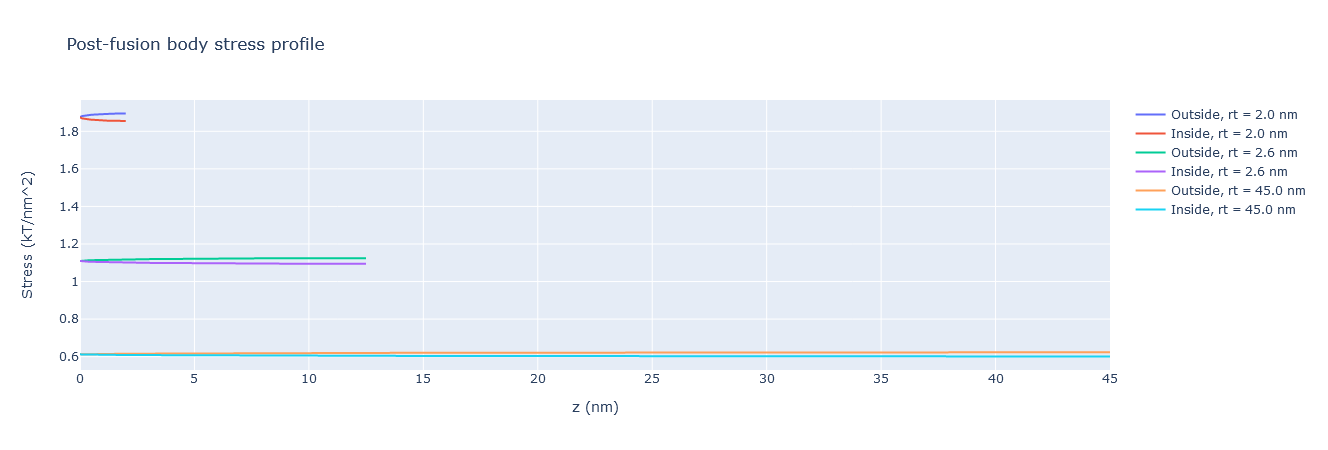

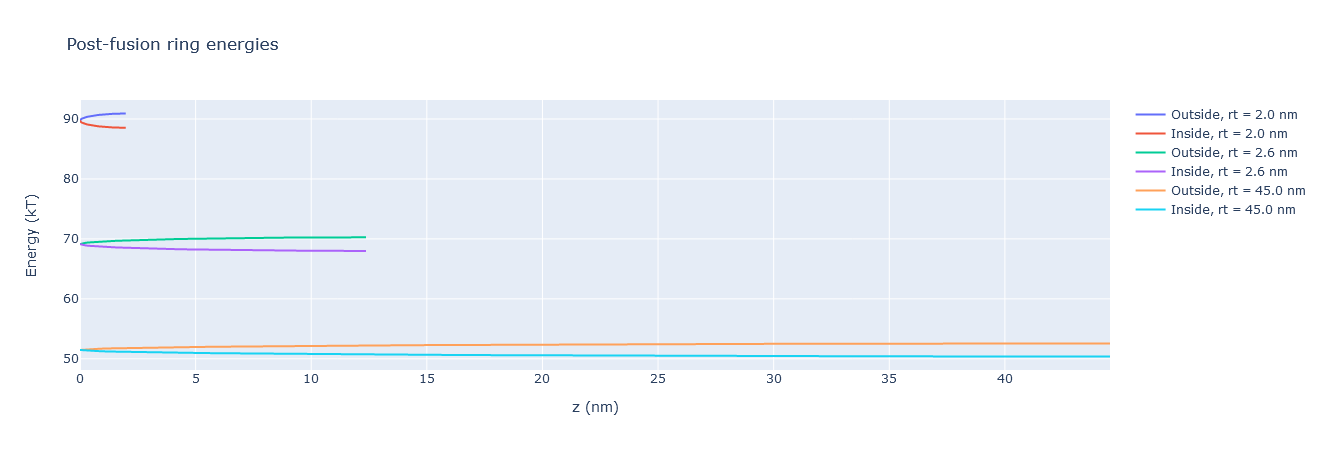

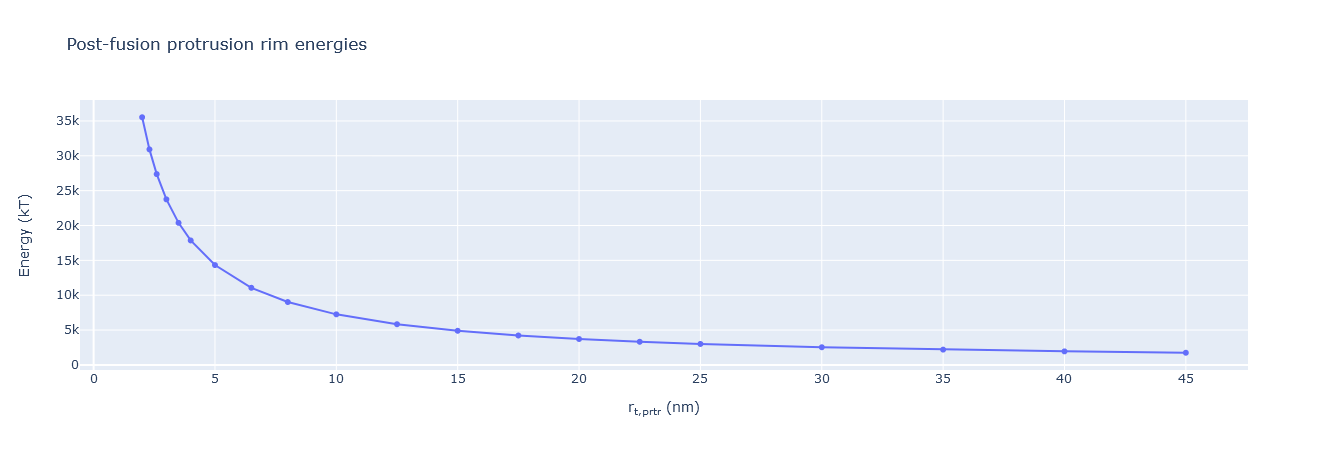

Total Gb of post-fusion protrusion rim in kT =  [35531.41292697 30921.36803435 27375.15693425 23750.11059425
 20383.95418976 17859.29626039 14324.67818649 11061.76884833
  9022.27214785  7254.48943206  5839.98648858  4896.73327573
  4222.77018888  3717.117384    3323.67490935  3008.78275847
  2536.10926207  2198.11641907  1944.3136221   1746.65020576]


In [9]:
zSteps = 100
zRim = [np.linspace(0,rim_rt[0],num=zSteps)] # nm
for rt in range(1,rim_rt.size):
    zRim.append(np.linspace(0,rim_rt[rt],num=zSteps))

uRim = np.zeros((rim_rt.size,zSteps,2)) # radians
    # rim tube angle for each rim_rt as a function of z where uRim1 = 0 is 
    # defined as pointing outward on the bisecting transverse plane
    # 3rd dimension to acct for the fact that each z has a u for the inner 
    # surface and a u for the outer surface

kRim = np.zeros((rim_rt.size,zSteps,2)) # 1/nm; curv for each angle u on rim
    # curvature for each rim_rt value at each zRim along the rim surface
stressRim = np.zeros((rim_rt.size,zSteps,2)) # kT/nm^2; stress at each point
GRingPost = np.zeros((rim_rt.size,zSteps-1,2)) # kT; G_b of each ring
    # zRim.size-1 since Reimann summing reduces num of elements by 1
GPost = np.zeros(rim_rt.size)

#First calculate the relevant angles
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        uRim[rt,z,0] = np.arcsin((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])  # Outside of torus
        uRim[rt,z,1] = np.pi - np.arcsin((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])  # Inside of torus
        
#Second calculate the curvatures
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        kRim[rt,z,0] = torusCircCurv(R0,rim_rt[rt],uRim[rt,z,0])
        kRim[rt,z,1] = torusCircCurv(R0,rim_rt[rt],uRim[rt,z,1])
#print(kRim)

#Next calculate the "stress" (energy per unit area) profile
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        stressRim[rt,z,0] = helfrichStress(kRim[rt,z,0],1/rim_rt[rt],Kb)
        stressRim[rt,z,1] = helfrichStress(kRim[rt,z,1],1/rim_rt[rt],Kb)
            # NOT Kb*2 since only a single bilayer bending now

# Now find the energy of the discrete uRim rings via left Riemann sum
# To do so, we first must find the radii of the inner ringers and the outer rings
R1Out = np.zeros((rim_rt.size,zSteps))
R1In = np.zeros((rim_rt.size,zSteps))
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        R1Out[rt,z] = R0 + rim_rt[rt] + np.sqrt(1-((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])**2) #out
        R1In[rt,z] = R0 + rim_rt[rt] - np.sqrt(1-((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])**2) #in
            #Dist from z axis to membrane at given z (using trig a identity)
# Now we'll find the energy of each ring via left Riemann sum
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps-1):
        # Stress per ring by finding cylindrical wall area * ring stress
        GRingPost[rt,z,0] = np.pi * 2*R1Out[rt,z] * (zRim[rt][1]-zRim[rt][0]) * stressRim[rt,z,0]
        GRingPost[rt,z,1] = np.pi * 2*R1In[rt,z] * (zRim[rt][1]-zRim[rt][0]) * stressRim[rt,z,1]

# Finally, we can find the total energy
# Add up all the rings' energies to get the total energy
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps-1):
        GPost[rt] += GRingPost[rt,z,0] + GRingPost[rt,z,1]
# Then multiply the result by 2 to reflect the 2 symmetric rims
GPost = GPost*2

#--------------------------------------------------------------------------------------------
# Graph the results
#--------------------------------------------------------------------------------------------
stressPlot = go.Figure()
stressPlot.add_trace(go.Scatter(x=zRim[0], y=stressRim[0,:,0], mode='lines', 
                                name='Outside, rt = {0} nm'.format(rim_rt[0])))
stressPlot.add_trace(go.Scatter(x=zRim[0], y=stressRim[0,:,1], mode='lines', 
                                name='Inside, rt = {0} nm'.format(rim_rt[0])))
stressPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=stressRim[2,:,0], mode='lines', 
                                name='Outside, rt = {0} nm'.format(rim_rt[2])))
stressPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=stressRim[2,:,1], mode='lines', 
                                name='Inside, rt = {0} nm'.format(rim_rt[2])))
stressPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=stressRim[4,:,0], mode='lines', 
                                name='Outside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
stressPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=stressRim[4,:,1], mode='lines', 
                                name='Inside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
stressPlot.update_layout(title="Post-fusion body stress profile",
                        xaxis_title="z (nm)", yaxis_title="Stress (kT/nm^2)")
stressPlot.show()

ringGPlot = go.Figure()
ringGPlot.add_trace(go.Scatter(x=zRim[0], y=GRingPost[0,:,0], mode='lines', 
                               name='Outside, rt = {0} nm'.format(rim_rt[0])))
ringGPlot.add_trace(go.Scatter(x=zRim[0], y=GRingPost[0,:,1], mode='lines', 
                               name='Inside, rt = {0} nm'.format(rim_rt[0])))
ringGPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=GRingPost[2,:,0], mode='lines', 
                               name='Outside, rt = {0} nm'.format(rim_rt[2])))
ringGPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=GRingPost[2,:,1], mode='lines', 
                               name='Inside, rt = {0} nm'.format(rim_rt[2])))
ringGPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=GRingPost[4,:,0], mode='lines', 
                               name='Outside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
ringGPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=GRingPost[4,:,1], mode='lines', 
                               name='Inside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
ringGPlot.update_layout(title="Post-fusion ring energies",
                        xaxis_title="z (nm)", yaxis_title="Energy (kT)")
ringGPlot.show()

postGPlot = go.Figure()
postGPlot.add_trace(go.Scatter(x=rim_rt, y=GPost, mode='markers + lines'))
postGPlot.update_layout(title="Post-fusion protrusion rim energies",
                        xaxis_title="r<sub>t,prtr</sub> (nm)", yaxis_title="Energy (kT)")
postGPlot.show()

print("Total Gb of post-fusion protrusion rim in kT = ",GPost)

"Simulation parameter" validation: 
- Logical trend in GPost1: PASS
- zRim values match desired values: PASS
- Sufficient z resolution: PASS
    - Each of the GPost1 change by less than 1 kT when increasing zSteps from 100 --> 1000

## Comparing pre-fusion energy vs post-fusion energy

Some relevant pore energies below.
Note that these numbers should not be taken at face-value since the hypothetical pores are huge.
Pore Gb for pore radius 400 nm, pore_rt = 15:  3569.3455980891786
Pore Gb for pore radius 400 nm, pore_rt = 25:  2090.8478991057846
Pore Gb for pore radius 400 nm, pore_rt = 50:  985.3105416057647


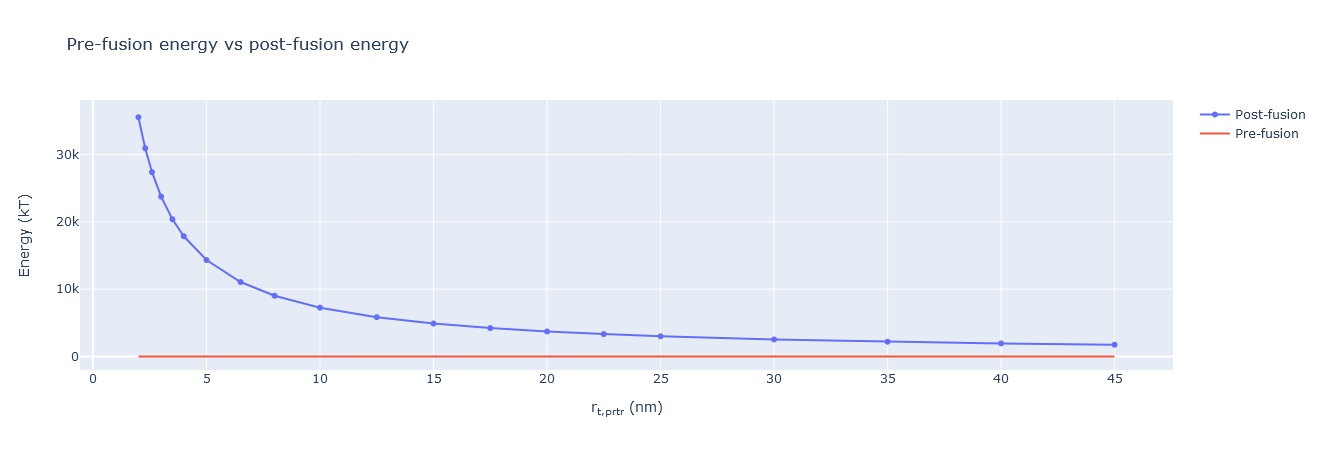

In [10]:
print("Some relevant pore energies below.")
print("Note that these numbers should not be taken at face-value since the hypothetical pores are huge.")
print("Pore Gb for pore radius 400 nm, pore_rt = 15: ",GToroidalPore(15,R0,Kb))
print("Pore Gb for pore radius 400 nm, pore_rt = 25: ",GToroidalPore(25,R0,Kb))
print("Pore Gb for pore radius 400 nm, pore_rt = 50: ",GToroidalPore(50,R0,Kb))

vsPlot = go.Figure()
vsPlot.add_trace(go.Scatter(x=rim_rt, y=GPost, mode='markers + lines', name='Post-fusion'))
vsPlot.add_trace(go.Scatter(x=rim_rt, y=GPre, mode='lines', name='Pre-fusion'))
vsPlot.update_layout(title="Pre-fusion energy vs post-fusion energy",
                        xaxis_title="r<sub>t,prtr</sub> (nm)", yaxis_title="Energy (kT)")
vsPlot.show()

If this is accurate, the energetic increase may decrease with greater $r_{t,rim}$, but fusion at the base is clearly an energy *intensive* process, not one that releases energy.

## Calculate pre vs post $G_b$ difference and export results

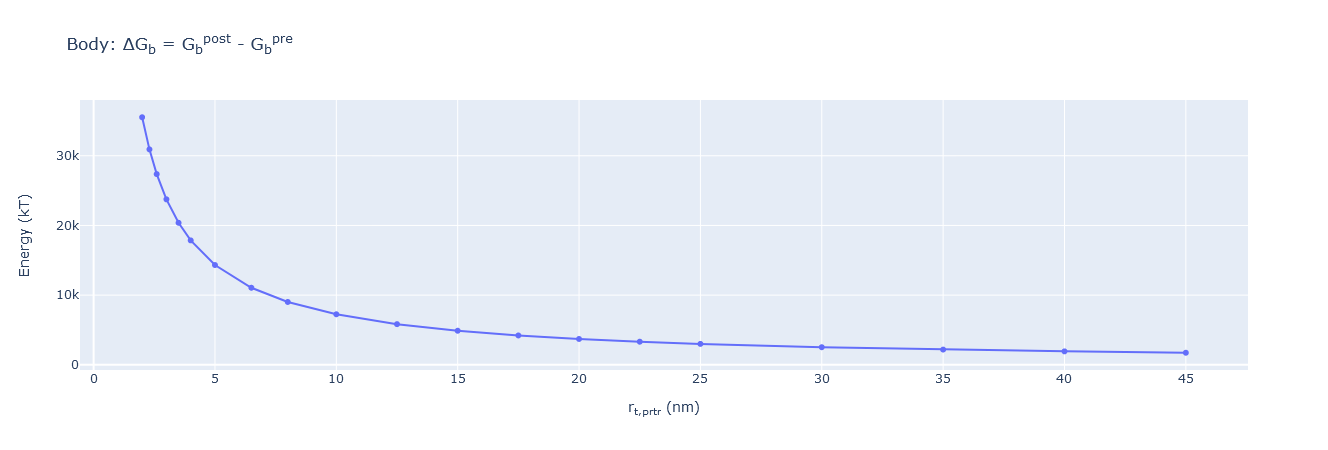

Saving DGb for body
Saving rim_rt for body
Done!


In [11]:
DGb = GPost - GPre

DGbPlot = go.Figure()
DGbPlot.add_trace(go.Scatter(x=rim_rt, y=DGb, mode='markers + lines'))
DGbPlot.update_layout(title="Body: ΔG<sub>b</sub> = G<sub>b</sub><sup>post</sup> - G<sub>b</sub><sup>pre</sup>",
                        xaxis_title="r<sub>t,prtr</sub> (nm)", yaxis_title="Energy (kT)")
DGbPlot.show()

print('Saving DGb for body')
np.savetxt('output data/Body DGb 2-0.csv', DGb, delimiter=',') # Export DGb as a versioned csv
print('Saving rim_rt for body')
np.savetxt('output data/Body rt 2-0.csv', rim_rt, delimiter=',') # Export rim_rt that was used
print('Done!')

In [12]:
DGbPlot.write_image("output data/Body DGb 2-0-5.pdf")